<a href="https://colab.research.google.com/github/jhuang12/Tensorflow-for-personality-items-classification/blob/master/191216TF_IPIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#THIS NOTEBOOK WAS CREATED TO USE TF NLP FOR IPIP ITEMS

In [1]:
#Mount Google Drive
from google.colab import drive
from os.path import join
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from os.path import join

GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/Tensorflow for IPIPs'
GIT_USERNAME = 'jhuang12'
GIT_TOKEN = '{token}'
GIT_REPOSITORY = 'Tensorflow-for-personality-items-classification'
PROJECT_PATH = join(ROOT, GOOGLE_DRIVE_PATH)
print('project_path:', PROJECT_PATH)

GIT_PATH = 'https://'+ GIT_TOKEN + '@github.com/' + GIT_USERNAME + '/' + GIT_REPOSITORY + '.git'
print('git_path:', GIT_PATH)

project_path: /content/drive/My Drive/Colab Notebooks/Tensorflow for IPIPs
git_path: https://509e0a9b97980dcebc55e03e3ce8f8ac90de6ac5@github.com/jhuang12/Tensorflow-for-personality-items-classification.git


In [0]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf

In [0]:
print(tf.__version__)

2.0.0


In [0]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 53kB/s 
     |████████████████████████████████| 450kB 67.3MB/s 
     |████████████████████████████████| 3.8MB 56.7MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

DATA LOADING

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dpath = os.path.join(r"C:/Users/amead/Google Drive/active/machine learning/big5/big_five_items.csv")
dpath = os.path.join("/content/drive/My Drive/big_five_items.csv")

In [0]:
data = pd.read_csv(dpath,low_memory=False, sep ="\t", lineterminator='\n', encoding='utf-8')

In [0]:
#with open(dpath, mode='rb') as f:
#    print(f.read())

b'#ID\tScale Item ID\tScale\tDirection\tStem\tInstrument\r\n1\t1\tNeuroticism\t-\tI seldom feel blue.\tBFAS\r\n2\t2\tAgreeableness\t-\tI am not interested in other people\'s problems.\tBFAS\r\n3\t3\tConscientiousness\t+\tI carry out my plans.\tBFAS\r\n4\t4\tExtraversion\t+\tI make friends easily.\tBFAS\r\n5\t5\tOpenness\t+\tI am quick to understand things.\tBFAS\r\n6\t6\tNeuroticism\t+\tI get angry easily.\tBFAS\r\n7\t7\tAgreeableness\t+\tI respect authority.\tBFAS\r\n8\t8\tConscientiousness\t-\tI leave my belongings around.\tBFAS\r\n9\t9\tExtraversion\t+\tI take charge.\tBFAS\r\n10\t10\tOpenness\t+\tI enjoy the beauty of nature.\tBFAS\r\n11\t11\tNeuroticism\t+\tI am filled with doubts about things.\tBFAS\r\n12\t12\tAgreeableness\t+\tI feel others\' emotions.\tBFAS\r\n13\t13\tConscientiousness\t-\tI waste my time.\tBFAS\r\n14\t14\tExtraversion\t-\tI am hard to get to know.\tBFAS\r\n15\t15\tOpenness\t-\tI have difficulty understanding abstract ideas.\tBFAS\r\n16\t16\tNeuroticism\t-\tI r

In [0]:
data.head()

,#ID,Scale Item ID,Scale,Direction,Stem,Instrument
0,1,1,Neuroticism,-,I seldom feel blue.,BFAS
1,2,2,Agreeableness,-,I am not interested in other people's problems.,BFAS
2,3,3,Conscientiousness,+,I carry out my plans.,BFAS
3,4,4,Extraversion,+,I make friends easily.,BFAS
4,5,5,Openness,+,I am quick to understand things.,BFAS


DATA PROCESSING


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 6 columns):
#ID              655 non-null int64
Scale Item ID    655 non-null object
Scale            655 non-null object
Direction        655 non-null object
Stem             655 non-null object
Instrument       655 non-null object
dtypes: int64(1), object(5)
memory usage: 30.8+ KB


In [0]:
data.shape

(655, 6)

In [0]:
#need to add random.sample() into the data so that the data are random
#the beter solution would be to do stratefied sampleing with five dimensions

In [0]:
#stem as one string
sentences = pd.Series(data['Stem'])
sentences

0                                    I seldom feel blue.
1        I am not interested in other people's problems.
2                                  I carry out my plans.
3                                 I make friends easily.
4                       I am quick to understand things.
                             ...                        
650                       I'm pretty stable emotionally.
651                                      I laugh easily.
652    I believe that the "new morality" of a permiss...
653    I would rather be known as "merciful" than as ...
654            I think twice before I answer a question.
Name: Stem, Length: 655, dtype: object

In [0]:
#scale as categorical data
data['labels'] = data['Scale'].astype('category').cat.codes
data.head()

,#ID,Scale Item ID,Scale,Direction,Stem,Instrument,labels
0,1,1,Neuroticism,-,I seldom feel blue.,BFAS,3
1,2,2,Agreeableness,-,I am not interested in other people's problems.,BFAS,0
2,3,3,Conscientiousness,+,I carry out my plans.,BFAS,1
3,4,4,Extraversion,+,I make friends easily.,BFAS,2
4,5,5,Openness,+,I am quick to understand things.,BFAS,4


In [0]:
labels = np.array(pd.Series(data['labels']))
labels

array([3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0,
       1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2,
       4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3,
       0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 3, 0, 1,
       2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 4, 2, 0, 1, 3, 4, 2, 0, 1, 3, 4,
       2, 0, 1, 3, 4, 2, 0, 1, 3, 4, 2, 0, 1, 3, 4, 2, 0, 1, 3, 4, 2, 0,
       1, 3, 4, 2, 0, 1, 3, 4, 4, 0, 1, 4, 4, 2, 2, 0, 2, 0, 3, 4, 4, 2,
       3, 2, 2, 2, 3, 2, 4, 1, 3, 1, 1, 0, 0, 1, 4, 1, 3, 0, 0, 0, 4, 4,
       4, 0, 2, 3, 4, 0, 1, 0, 1, 0, 3, 1, 2, 3, 3, 1, 2, 2, 3, 0, 2, 1,
       3, 3, 4, 0, 1, 1, 2, 0, 4, 0, 2, 1, 3, 0, 4, 1, 4, 1, 3, 1, 3, 1,
       3, 1, 1, 1, 2, 4, 4, 3, 3, 1, 4, 0, 4, 2, 2, 3, 4, 3, 3, 0, 0, 2,
       3, 1, 3, 1, 1, 1, 3, 1, 2, 0, 4, 0, 2, 1, 4, 1, 2, 0, 2, 3, 4, 2,
       3, 0, 2, 0, 4, 3, 4, 4, 4, 0, 2, 4, 4, 0, 1, 1, 4, 0, 3, 0, 1, 2,
       3, 1, 2, 3, 0, 2, 0, 0, 4, 1, 3, 3, 3, 3, 4,

DATA CLEANING (STEMMING)

TOKENIZATION AND PADDING

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token = "<OOV>", num_words = 10000)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding = 'pre')
print(padded[0])
print(padded.shape)

{'<OOV>': 1, 'i': 2, 'to': 3, 'a': 4, 'of': 5, 'am': 6, 'and': 7, 'my': 8, 'the': 9, 'have': 10, 'in': 11, 'people': 12, 'things': 13, 'be': 14, 'others': 15, 'feel': 16, 'get': 17, 'is': 18, 'with': 19, 'not': 20, "i'm": 21, 'or': 22, 'easily': 23, 'for': 24, 'me': 25, 'myself': 26, 'that': 27, 'like': 28, 'do': 29, 'when': 30, 'often': 31, 'on': 32, 'sometimes': 33, 'can': 34, 'as': 35, 'about': 36, 'at': 37, 'lot': 38, 'it': 39, 'work': 40, "don't": 41, 'them': 42, 'make': 43, 'take': 44, 'rarely': 45, 'believe': 46, 'than': 47, 'person': 48, 'think': 49, 'seldom': 50, 'time': 51, 'know': 52, 'up': 53, 'other': 54, 'keep': 55, 'feelings': 56, 'if': 57, 'ideas': 58, 'find': 59, 'very': 60, 'most': 61, 'try': 62, 'enjoy': 63, 'what': 64, 'by': 65, 'good': 66, 'done': 67, 'an': 68, 'always': 69, 'are': 70, 'around': 71, 'love': 72, 'way': 73, 'into': 74, 'would': 75, 'just': 76, 'problems': 77, "others'": 78, 'emotions': 79, 'being': 80, 'difficult': 81, 'little': 82, 'avoid': 83, 'min

TRAINING

In [0]:
import random 
random.seed(700)

array(['Neuroticism', 'Agreeableness', 'Conscientiousness',
       'Extraversion', 'Openness'], dtype=object)

In [0]:
#stratified training and validation sample with dimensions
training_data = []
training_labels = []
validation_data = []
validation_labels = []

for s in range(5):
  print(s)
  training_set = data.loc[data['labels'] == s, 'Stem'].sample(frac = 0.7, replace = False, random_state = 1)
  training_l = np.array([s]*len(training_set))

  validation_set = data.loc[(~data['Stem'].isin(training_set)) & (data['labels'] == s), 'Stem']
  validation_l = np.array([s]*len(validation_set))

  print(len(training_set))
  print(len(validation_set))

  training_data.extend(training_set)
  training_labels.extend(training_l)

  validation_data.extend(validation_set)
  validation_labels.extend(validation_l)

  print(len(training_data))
  print(len(validation_data))


0
92
35
92
35
1
92
39
184
74
2
91
38
275
112
3
91
34
366
146
4
93
37
459
183


In [0]:
#split training and validation sample
#training_data, training_labels = np.asarray(padded[ :524]), labels[ :524]
#test_data, test_labels = np.asarray(padded[525: ]), labels[525: ]

In [0]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words = 10000)
tokenizer.fit_on_texts(training_data)
word_index_training = tokenizer.word_index
#print(word_index_training)

sequences_training = tokenizer.texts_to_sequences(training_data)
padded_training = pad_sequences(sequences_training, padding = 'pre')

tokenizer.fit_on_texts(validation_data)
word_index_validation = tokenizer.word_index
#print(word_index_training)

sequences_validation = tokenizer.texts_to_sequences(validation_data)
padded_validation = pad_sequences(sequences_validation, padding = 'pre')

In [0]:
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

In [0]:
#summary of tokenization - validation data
print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)

OrderedDict([('harsh', 1), ('i', 424), ('am', 58), ('not', 26), ('interested', 4), ('in', 48), ('other', 10), ("people's", 3), ('problems', 6), ('often', 21), ('get', 29), ('into', 8), ('arguments', 2), ('with', 30), ('my', 58), ('family', 1), ('and', 61), ('co', 1), ('workers', 1), ('hate', 2), ('to', 138), ('seem', 4), ('pushy', 1), ('kind', 3), ('show', 2), ('gratitude', 1), ('being', 7), ('perfectly', 1), ('honest', 2), ('is', 32), ('a', 91), ('bad', 1), ('way', 8), ('do', 21), ('business', 1), ('when', 21), ("i've", 3), ('been', 3), ('insulted', 1), ('just', 8), ('try', 10), ('forgive', 1), ('forget', 2), ('some', 4), ('people', 48), ('think', 13), ('of', 69), ('me', 24), ('as', 18), ('cold', 5), ('calculating', 1), ('love', 8), ('good', 9), ('fight', 1), ('pride', 2), ('myself', 22), ('on', 20), ('shrewdness', 1), ('handling', 2), ('children', 1), ('uncooperative', 2), ('hesitate', 1), ('express', 1), ('anger', 1), ('even', 4), ("it's", 3), ('justified', 1), ('warm', 4), ('stingy

In [0]:
SHOULD TRAINING AND VALIDATION DATA TOKENIZED TOGETHER OR SEPERATELY?

MODEL 

In [0]:
padded_training

array([[  0,   0,   0, ...,   0,   0, 301],
       [  0,   0,   0, ...,  54, 171, 172],
       [  0,   0,   0, ...,   7, 303, 304],
       ...,
       [  0,   0,   0, ...,   5, 166, 824],
       [  0,   0,   0, ...,   0,   0, 825],
       [  0,   0,   0, ..., 284,  23, 827]], dtype=int32)

In [0]:
training_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [0]:
#ACCURACY_STOP = 0.95

class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy')> 0.95):
      self.model.stop_training = True
      print("\nReach accuracy of 95% and stop training!")

callbacks = myCallbacks()

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_directory = '/content/drive/My Drive/NLP_tensorflow/sequentia_model.h5'

checkpoint = ModelCheckpoint(checkpoint_directory,
                             monitor = "val_accuracy", 
                             save_best_only = True, 
                             mode = 'max')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 16),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          16000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 28,517
Trainable params: 28,517
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [0]:
#NUM_EPOCHS = 10
history = model.fit(padded_training, training_labels,
                    validation_data=(padded_validation, validation_labels),
                    epochs=30, 
                    callbacks = [checkpoint, callbacks])

Train on 459 samples, validate on 183 samples
Epoch 1/30
459/459 [==============================] - 1s 3ms/sample - loss: 1.6106 - accuracy: 0.1983 - val_loss: 1.6086 - val_accuracy: 0.1967
Epoch 2/30
459/459 [==============================] - 0s 199us/sample - loss: 1.6090 - accuracy: 0.1983 - val_loss: 1.6088 - val_accuracy: 0.2131
Epoch 3/30
459/459 [==============================] - 0s 172us/sample - loss: 1.6076 - accuracy: 0.2418 - val_loss: 1.6085 - val_accuracy: 0.1803
Epoch 4/30
459/459 [==============================] - 0s 156us/sample - loss: 1.6047 - accuracy: 0.2636 - val_loss: 1.6073 - val_accuracy: 0.2022
Epoch 5/30
459/459 [==============================] - 0s 137us/sample - loss: 1.5972 - accuracy: 0.4009 - val_loss: 1.6059 - val_accuracy: 0.2077
Epoch 6/30
459/459 [==============================] - 0s 147us/sample - loss: 1.5810 - accuracy: 0.2854 - val_loss: 1.6032 - val_accuracy: 0.2077
Epoch 7/30
459/459 [==============================] - 0s 152us/sample - loss: 1.

MODEL PERFORMANCE

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

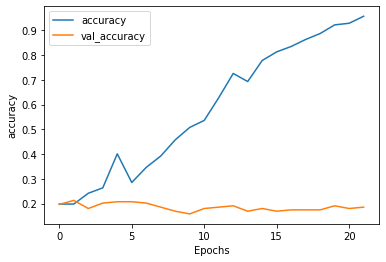

In [0]:
plot_graphs(history, 'accuracy')

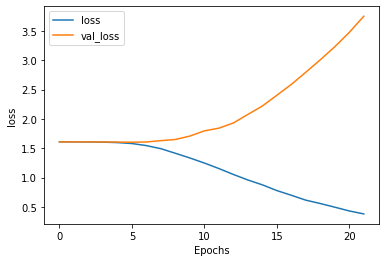

In [0]:
plot_graphs(history, 'loss')

USE SINGLE LAYER LSTM

In [0]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 138,629
Trainable params: 138,629
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [0]:
model1.fit(training_data, training_labels,
                    validation_data=(test_data, test_labels),
                    epochs=30, 
                    callbacks = [ callbacks])

Train on 524 samples, validate on 130 samples
Epoch 1/30
524/524 [==============================] - 4s 7ms/sample - loss: 1.6114 - accuracy: 0.1698 - val_loss: 1.6081 - val_accuracy: 0.2615
Epoch 2/30
524/524 [==============================] - 0s 878us/sample - loss: 1.6036 - accuracy: 0.3130 - val_loss: 1.6047 - val_accuracy: 0.2462
Epoch 3/30
524/524 [==============================] - 0s 860us/sample - loss: 1.5803 - accuracy: 0.3989 - val_loss: 1.5904 - val_accuracy: 0.2692
Epoch 4/30
524/524 [==============================] - 0s 920us/sample - loss: 1.4938 - accuracy: 0.5706 - val_loss: 1.5262 - val_accuracy: 0.3154
Epoch 5/30
524/524 [==============================] - 0s 838us/sample - loss: 1.2412 - accuracy: 0.4981 - val_loss: 1.4824 - val_accuracy: 0.3308
Epoch 6/30
524/524 [==============================] - 0s 857us/sample - loss: 0.9039 - accuracy: 0.6679 - val_loss: 1.5757 - val_accuracy: 0.3231
Epoch 7/30
524/524 [==============================] - 0s 863us/sample - loss: 0.

USE MULTIPLE LAYER LSTM

In [0]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 175,749
Trainable params: 175,749
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
)

In [0]:
model2.fit(training_data, training_labels,
           validation_data=(test_data, test_labels),
           epochs=30, 
           callbacks = [ callbacks])

Train on 524 samples, validate on 130 samples
Epoch 1/30
524/524 [==============================] - 7s 13ms/sample - loss: 1.6113 - accuracy: 0.1832 - val_loss: 1.6093 - val_accuracy: 0.1538
Epoch 2/30
524/524 [==============================] - 1s 2ms/sample - loss: 1.6056 - accuracy: 0.2195 - val_loss: 1.6075 - val_accuracy: 0.2000
Epoch 3/30
524/524 [==============================] - 1s 2ms/sample - loss: 1.5872 - accuracy: 0.3607 - val_loss: 1.5987 - val_accuracy: 0.2692
Epoch 4/30
524/524 [==============================] - 1s 1ms/sample - loss: 1.3670 - accuracy: 0.5458 - val_loss: 1.8439 - val_accuracy: 0.2769
Epoch 5/30
524/524 [==============================] - 1s 2ms/sample - loss: 0.7848 - accuracy: 0.6927 - val_loss: 2.0417 - val_accuracy: 0.3308
Epoch 6/30
524/524 [==============================] - 1s 2ms/sample - loss: 0.3752 - accuracy: 0.8912 - val_loss: 2.7186 - val_accuracy: 0.3385
Epoch 7/30
512/524 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 

USE GRU

In [0]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64, input_length=24),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 64)            64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 35        
Total params: 83,241
Trainable params: 83,241
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3.fit(training_data, training_labels,
                    validation_data=(test_data, test_labels),
                    epochs=30, 
                    callbacks = [ callbacks])

Train on 524 samples, validate on 130 samples
Epoch 1/30
524/524 [==============================] - 4s 7ms/sample - loss: 1.6102 - accuracy: 0.2099 - val_loss: 1.6057 - val_accuracy: 0.2462
Epoch 2/30
524/524 [==============================] - 0s 662us/sample - loss: 1.5952 - accuracy: 0.2538 - val_loss: 1.6034 - val_accuracy: 0.2000
Epoch 3/30
524/524 [==============================] - 0s 628us/sample - loss: 1.5684 - accuracy: 0.2309 - val_loss: 1.5907 - val_accuracy: 0.2308
Epoch 4/30
524/524 [==============================] - 0s 686us/sample - loss: 1.5167 - accuracy: 0.2653 - val_loss: 1.5860 - val_accuracy: 0.2231
Epoch 5/30
524/524 [==============================] - 0s 658us/sample - loss: 1.4132 - accuracy: 0.3588 - val_loss: 1.6173 - val_accuracy: 0.3231
Epoch 6/30
524/524 [==============================] - 0s 630us/sample - loss: 1.2616 - accuracy: 0.4866 - val_loss: 1.5625 - val_accuracy: 0.3538
Epoch 7/30
524/524 [==============================] - 0s 637us/sample - loss: 1.

In [0]:
#clear the trained models
tf.keras.backend.clear_session()